# FineTuning BERT for Multi-Class Classification with custom datasets



In [2]:
# !pip install transformers datasets

In [3]:
import pandas as pd
from datasets import load_dataset
import matplotlib.pyplot as plt
import torch, os
from torch.utils.data import Dataset

In [4]:
dataset = load_dataset("trec")


In [5]:
df = dataset['train'].to_pandas()
df

,text,coarse_label,fine_label
0,How did serfdom develop in and then leave Russ...,2,26
1,What films featured the character Popeye Doyle ?,1,5
2,How can I find a list of celebrities ' real na...,2,26
3,What fowl grabs the spotlight after the Chines...,1,2
4,What is the full form of .com ?,0,1
...,...,...,...
5447,What 's the shape of a camel 's spine ?,1,13
5448,What type of currency is used in China ?,1,6
5449,What is the temperature today ?,5,47
5450,What is the temperature for cooking ?,5,47


In [6]:
from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'
device 

'cpu'

In [7]:
labels = df['coarse_label'].unique().tolist()
len(labels)

6

In [8]:
NUM_LABELS= len(labels)

id_to_label= {0 : 'ABBR' , 1 : 'ENTY', 2: 'DESC', 3 : 'HUM', 4 : 'LOC', 5 : 'NUM'}

label_to_id= { 'ABBR' : 0 , 'ENTY' : 1, 'DESC': 2, 'HUM' :3, 'LOC' : 4, 'NUM' : 5}

(array([  86.,    0., 1250.,    0., 1162.,    0., 1223.,    0.,  835.,
         896.]),
 array([0. , 0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. ]),
 <BarContainer object of 10 artists>)

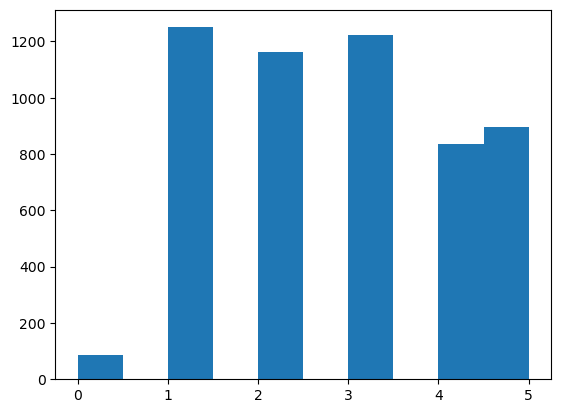

In [9]:
plt.hist(df['coarse_label'])

In [10]:
df['coarse_label'].skew()

0.15597232763622962

In [11]:
SIZE= df.shape[0]
print(SIZE)

train_texts= list(df.text[:SIZE//2])

val_texts=   list(df.text[SIZE//2:(3*SIZE)//4 ])

test_texts=  list(df.text[(3*SIZE)//4:])

train_labels= list(df.coarse_label[:SIZE//2])

val_labels=   list(df.coarse_label[SIZE//2:(3*SIZE)//4])

test_labels=  list(df.coarse_label[(3*SIZE)//4:])

5452


In [12]:
from transformers import BertTokenizerFast

In [13]:
tokenizer = BertTokenizerFast.from_pretrained("bert-base-uncased", max_length=512)

In [14]:
train_encodings = tokenizer(train_texts, truncation=True, padding=True)
val_encodings = tokenizer(val_texts, truncation=True, padding=True)
test_encodings = tokenizer(test_texts, truncation=True, padding=True)

In [15]:
from transformers import pipeline, BertForSequenceClassification

In [16]:
id_to_label = {0 : 'ABBR' , 1 : 'ENTY', 2: 'DESC', 3 : 'HUM', 4 : 'LOC', 5 : 'NUM'}
label_to_id= { 'ABBR' : 0 , 'ENTY' : 1, 'DESC': 2, 'HUM' :3, 'LOC' : 4, 'NUM' : 5}

In [17]:
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=len(labels), id2label=id_to_label, label2id=label_to_id)


In [18]:
from transformers import TrainingArguments, Trainer

In [19]:
training_args = TrainingArguments(
    # The output directory where the model predictions and checkpoints will be written
    output_dir='./TTC4900Model',
    do_train=True,
    do_eval=True,
    #  The number of epochs, defaults to 3.0
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    # Number of steps used for a linear warmup
    warmup_steps=100,
    weight_decay=0.01,
    logging_strategy='steps',
   # TensorBoard log directory
    logging_dir='./multi-class-logs',
    logging_steps=50,
    evaluation_strategy="steps",
    eval_steps=50,
    save_strategy="steps",
)

In [20]:
class DataLoader(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels
    def __getitem__(self, idx):
        """
          This construct a dict that is (index position) to encoding pairs.
          Where the Encoding becomes tensor(Encoding), which is an requirements
          for training the model
        """
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item
    def __len__(self):
        """
        Returns the number of data items in the dataset.

        """
        return len(self.labels)

In [21]:
train_dataloader = DataLoader(train_encodings, train_labels)
val_dataloader = DataLoader(val_encodings,val_labels)
test_dataloader = DataLoader(test_encodings,test_labels)

In [22]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

In [23]:
def compute_metrics(pred):

    # Extract true labels from the input object
    labels = pred.label_ids

    # Obtain predicted class labels by finding the column index with the maximum probability
    preds = pred.predictions.argmax(-1)

    # Compute macro precision, recall, and F1 score using sklearn's precision_recall_fscore_support function
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='macro',zero_division=1)

    # Calculate the accuracy score using sklearn's accuracy_score function
    acc = accuracy_score(labels, preds)

    # Return the computed metrics as a dictionary
    return {
        'Accuracy': acc,
        'F1': f1,
        'Precision': precision,
        'Recall': recall
    }

In [24]:
trainer = Trainer(
    #the pre-trained bert model that will be fine-tuned
    model=model,
    #training arguments that we defined above
    args=training_args,
    train_dataset= train_dataloader,
    eval_dataset = val_dataloader,
    compute_metrics= compute_metrics
)

In [28]:
#trainer.train()

In [27]:
#evaluation_series =[trainer.evaluate(eval_dataset=data) for data in [train_dataloader, val_dataloader, test_dataloader]]


In [29]:
model_path = "bert-base-uncased"

trainer.save_model(model_path)
tokenizer.save_pretrained(model_path)

('bert-base-uncased\\tokenizer_config.json',
 'bert-base-uncased\\special_tokens_map.json',
 'bert-base-uncased\\vocab.txt',
 'bert-base-uncased\\added_tokens.json',
 'bert-base-uncased\\tokenizer.json')

In [31]:
model_path = "bert-base-uncased"

model = BertForSequenceClassification.from_pretrained(model_path)
tokenizer= BertTokenizerFast.from_pretrained(model_path)
nlp= pipeline("sentiment-analysis", model=model, tokenizer=tokenizer)

In [32]:
df[['text','coarse_label']].iloc[(3*SIZE)//4:]

,text,coarse_label
4089,What 's the second-most-used murder weapon in ...,1
4090,What businesses or agencies would do an employ...,3
4091,What famous coach said `` if you can 't beat '...,3
4092,What onetime member of Ronald Reagan 's cabine...,3
4093,How many claws has a lobster called a pistol l...,5
...,...,...
5447,What 's the shape of a camel 's spine ?,1
5448,What type of currency is used in China ?,1
5449,What is the temperature today ?,5
5450,What is the temperature for cooking ?,5


In [33]:
def prediction(text):
  input_ids = tokenizer(text, return_tensors="pt", padding=True, truncation=True)
  input_ids = input_ids
  with torch.no_grad():
    outputs = model(**input_ids)
  logits = outputs.logits
  predicted_probabilities = torch.softmax(logits,dim=1)
  predicted_label_id = torch.argmax(predicted_probabilities, dim=1).item()
  predicted_label = id_to_label[predicted_label_id]
  return predicted_label_id

In [34]:
predictions = []
for text in test_texts[:30]:
  predictions.append(prediction(text))

In [35]:
y_test = df['coarse_label'].iloc[(3*SIZE)//4:].to_list()

In [36]:
pd.DataFrame( {'pred' : predictions, 'actual' : y_test[:30] })

,pred,actual
0,1,1
1,3,3
2,3,3
3,3,3
4,5,5
5,3,3
6,1,1
7,1,1
8,2,2
9,3,3
